In [2]:
from sklearn import datasets
import warnings
import optuna
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
import shap
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from pymoo.factory import get_performance_indicator
from optuna.exceptions import TrialPruned
from autocluster.autohypothesis import autohypothesis_utils

In [3]:
sk_wine = datasets.load_wine()
wine = pd.DataFrame(sk_wine['data'], columns=sk_wine['feature_names'])
wine['target'] = sk_wine['target']



In [4]:
import pandas as pd
import numpy as np

# Initialisation de la liste pour stocker les résultats
results = []

# Nombre de runs
n_runs = 1  # Définissez n selon votre besoin

for run in range(n_runs):
    # Exécutez le code original
    exp, X_train, X_dev, y_train, y_dev = autohypothesis_utils.opti_loop(wine, 500, optimize_obj="solo")
    all_objectives = np.array([trial.values for trial in exp.best_trials])
    sorted_objectives = all_objectives[np.argsort(all_objectives[:, 0])]
    params = autohypothesis_utils.get_trial_hyperparams(exp, trial_number=exp.best_trials[0].number)
    pipeline = autohypothesis_utils.rebuild_pipeline_with_hyperparams(params)
    pipeline.fit(X_train, y_train)
    acc = accuracy_score(y_dev, pipeline.predict(X_dev))
    entropy = autohypothesis_utils.clusterEntropy(pipeline, X_dev, pipeline.predict(X_dev))
    
    # Stockage des résultats pour cette itération
    results.append({
        "run_number": run + 1,
        "accuracy": acc,
        "entropy": 1 - entropy,
        "params": exp.best_trials[0].params
    })

# Création du DataFrame pour toutes les runs
df_runs = pd.DataFrame(results)

# Calcul de la moyenne des accuracies et entropies
avg_accuracy = np.mean(df_runs["accuracy"])
avg_entropy = np.mean(df_runs["entropy"])

# Création du DataFrame pour les moyennes
df_avg = pd.DataFrame([{
    "avg_accuracy": avg_accuracy,
    "avg_entropy": avg_entropy
}])

print(df_runs)
print(df_avg)


[I 2024-04-25 13:54:01,920] A new study created in memory with name: no-name-040a8c8c-1a11-4cb2-afe5-b3eba37262de
[I 2024-04-25 13:54:02,588] Trial 0 finished with value: 0.3888888888888889 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 970, 'rf_max_depth': 6, 'rf_min_samples_split': 0.35067695339569355, 'rf_min_samples_leaf': 0.39407738805592335, 'rf_max_features': 'sqrt', 'rf_random_state': 42}. Best is trial 0 with value: 0.3888888888888889.
[I 2024-04-25 13:54:02,840] Trial 1 finished with value: 0.9629629629629629 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 350, 'rf_max_depth': 19, 'rf_min_samples_split': 0.33750148483258835, 'rf_min_samples_leaf': 0.2480651230411716, 'rf_max_features': 'log2', 'rf_random_state': 42}. Best is trial 1 with value: 0.9629629629629629.
[I 2024-04-25 13:54:03,247] Trial 2 finished with value: 0.3888888888888889 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 580, 'rf_max_depth': 2, 'rf_min_samp

   run_number  accuracy   entropy  \
0           1       1.0  0.828406   

                                              params  
0  {'classifier': 'RandomForest', 'rf_n_estimator...  
   avg_accuracy  avg_entropy
0           1.0     0.828406


In [5]:
df_runs.to_csv("runs_solo_wine_500.csv")
df_avg.to_csv("avg_solo_wine_500.csv")

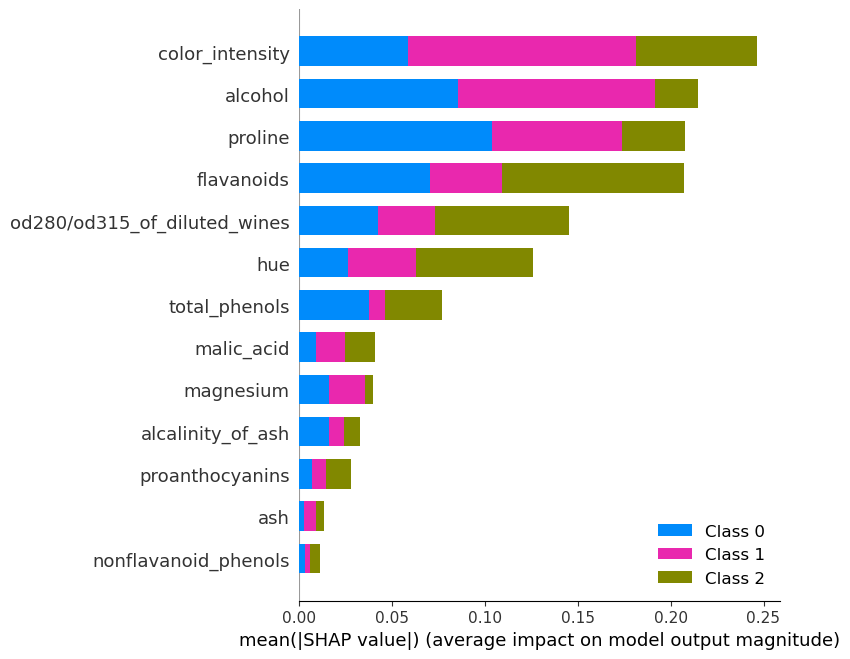

In [6]:
import shap

# Initialize your explainer
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
explain_shap = explainer(X_dev)
# Compute SHAP values
shap_values = explainer.shap_values(X_dev)

# Summarize the SHAP values in a plot
shap.summary_plot(shap_values, X_dev)


In [7]:
import numpy as np

unique_classes = np.unique(y_dev)
random_ids = {}

for cls in unique_classes:
    # Obtenir les indices de toutes les instances de cette classe
    class_indices = np.where(y_dev == cls)[0]
    # Sélectionner aléatoirement un indice parmi ces indices
    random_id = np.random.choice(class_indices)
    random_ids[cls] = random_id

print(random_ids)


{0: 53, 1: 29, 2: 48}


In [8]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][random_ids[0]], X_dev.iloc[random_ids[0]])


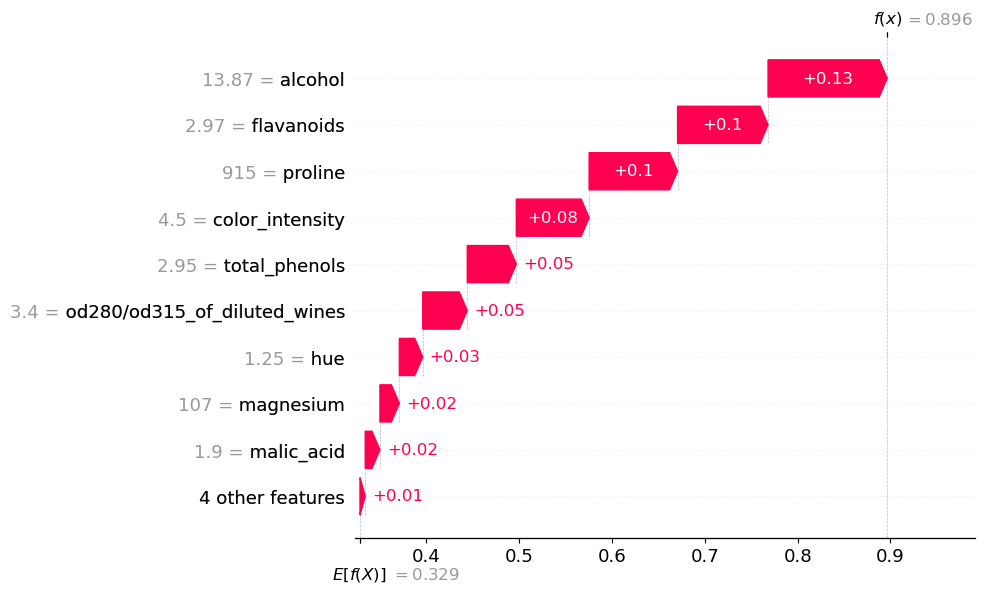

In [9]:
row = random_ids[0]
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [10]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][random_ids[1]], X_dev.iloc[random_ids[1]])

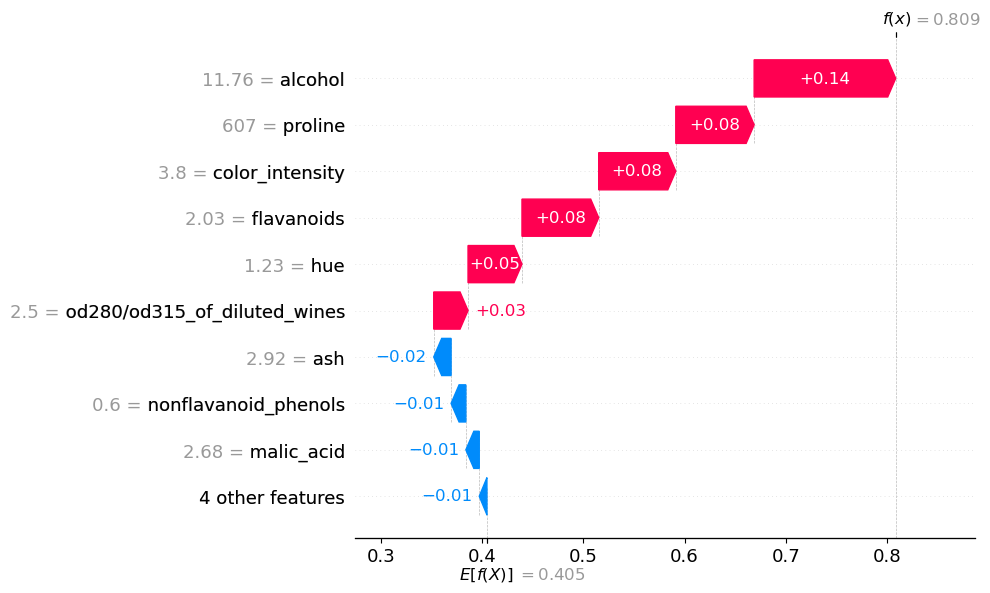

In [11]:
row = random_ids[1]
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [12]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][random_ids[2]], X_dev.iloc[random_ids[2]])

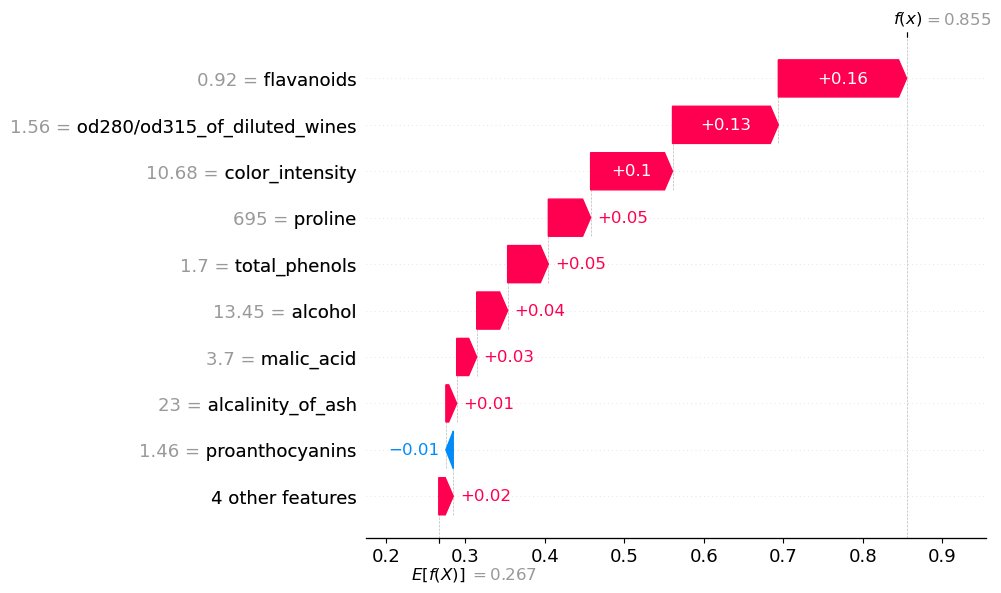

In [13]:
row = random_ids[2]
shap.waterfall_plot(shap.Explanation(values=shap_values[2][row], 
                                              base_values=explainer.expected_value[2], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [14]:
# Supposons que X_train, y_train, X_dev, et y_dev soient déjà définis
df = pd.read_csv('backup optuna 2000/runs_solo_wine.csv')
df

,Unnamed: 0,run_number,accuracy,entropy,params
0,0,1,0.981481,0.870953,"{'classifier': 'RandomForest', 'rf_n_estimator..."
1,1,2,0.981481,0.851452,"{'classifier': 'RandomForest', 'rf_n_estimator..."
2,2,3,0.981481,0.865266,"{'classifier': 'RandomForest', 'rf_n_estimator..."
3,3,4,0.981481,0.816108,"{'classifier': 'RandomForest', 'rf_n_estimator..."
4,4,5,0.981481,0.900549,"{'classifier': 'RandomForest', 'rf_n_estimator..."
5,5,6,0.981481,0.870601,"{'classifier': 'RandomForest', 'rf_n_estimator..."
6,6,7,0.981481,0.823255,"{'classifier': 'RandomForest', 'rf_n_estimator..."
7,7,8,0.981481,0.803883,"{'classifier': 'RandomForest', 'rf_n_estimator..."
8,8,9,0.981481,0.845018,"{'classifier': 'RandomForest', 'rf_n_estimator..."
9,9,10,0.981481,0.886325,"{'classifier': 'RandomForest', 'rf_n_estimator..."


In [15]:

df = autohypothesis_utils.compute_shap_std_for_models(df, X_train, y_train, X_dev, y_dev)
df

AttributeError: module 'shap.explainers' has no attribute 'LinearExplainer'